# Task e

Frederik Rogge, Mouhammad Abu Rasheed and Homa Priya Tarigopula

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.utils import resample
import os
%matplotlib inline

from utils import *
from resampling import *
np.random.seed(0)


In [2]:
# Create data
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x, y)

# Compute z
z = FrankeFunction(x, y)

# Create features as pairs of (x, y)
features = np.stack([x.ravel(), y.ravel()], axis=1)


# Get labels
labels = z.ravel()
labels = labels.reshape((-1,1))


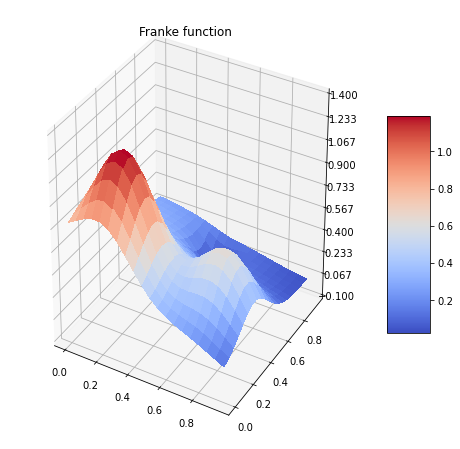

In [3]:
def plot_function(x, y, z, title=None):
    # Plot function
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface.
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    if title is not None:
        plt.title(title)
    
    plt.show()
    
plot_function(x, y, z, 'Franke function')

### Part e) : Bootstrap Resampling technique

In [4]:
def bootstrap(features, labels ,n_datapoints , degree_values, scaling= True , add_noise= True, mean = 0, std = 1, solver = LinearRegression, n_bootstraps = 1000,**solver_args):
  
    Maxpolydegree = np.max(degree_values)

    error_test = np.zeros((Maxpolydegree,  len(n_datapoints)))
    bias_test = np.zeros((Maxpolydegree,  len(n_datapoints)))
    variance_test = np.zeros((Maxpolydegree,  len(n_datapoints)))

    error_train = np.zeros((Maxpolydegree,  len(n_datapoints)))
    bias_train = np.zeros((Maxpolydegree,  len(n_datapoints)))
    variance_train = np.zeros((Maxpolydegree,  len(n_datapoints)))

    if add_noise :
        np.random.seed(1)
        labels_n = labels +  np.random.normal(mean, std, labels.shape )
    else :
        labels_n = labels
    
    # Hold out some test data that is never used in training.
    Xtrain, X_test, ytrain, y_test = train_test_split(features, labels_n, 
                                                        test_size=0.2, random_state = 2021)
   
    for n,k in enumerate(n_datapoints) :
      
        chosen_indices = np.random.choice(len(ytrain), int(k*len(ytrain)), replace=False)
        
        # choosing a  subset of train data points
        X_train, y_train =  Xtrain[chosen_indices], ytrain[chosen_indices]
    
        for nd, degree in enumerate(degree_values):
            # Input features transformation 
            poly = PolynomialFeatures(degree = degree, include_bias = False)
            x_train = poly.fit_transform(X_train)
            x_test = poly.fit_transform(X_test)

            if scaling:
                # Scale data
                scaler = StandardScaler(with_std=True)
                x_train= scaler.fit_transform(x_train)
                x_test = scaler.transform(x_test)
            else:
                x_train = x_train
                x_test = x_test
                
            bs = Bootstrap()
                    
            error_test[nd,n], bias_test[nd,n], variance_test[nd,n], error_train[nd,n], bias_train[nd,n], variance_train[nd,n] = bs.resample(x_train, x_test, y_train, y_test, solver, n_bootstraps= n_bootstraps,**solver_args)
            
            #print('Polynomial degree:', degree)
            #print('Error:', error_test[nd,n])
            #print('Bias^2:', bias_test[nd,n])
            #print('Var:', variance_test[nd,n])
            #print('{} >= {} + {} = {}'.format(error_test[nd,n], bias_test[nd,n], variance_test[nd,n], bias_test[nd,n]+variance_test[nd,n]))

    return error_test, bias_test, variance_test,error_train , bias_train , variance_train 



In [5]:
def gen_plot(n_datapoints, polynomial, estimated_mse, title , y_label, legend_label, fig_name):
    fig, ax = plt.subplots()
    for n,k in enumerate(n_datapoints):
        ax.plot(polynomial, np.log10(estimated_mse[:, n]), label= legend_label +', % of train data = '+ str(k)  )
        ax.set_xlabel('Polynomial degree')
        ax.set_ylabel( y_label)
        ax.set_xticks(polynomial)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title(title)
    plt.show()
    

In [6]:
n_bootstraps = 100
degree_values = np.arange(1, 5)  # Specify degree of polynomial to be fitted

n_datapoints = [0.5, 0.75, 1.0]

Lambda = [1e0, 1e-1, 1e-2, 1e-3 ]    # different values of Lambda

# define the model we want to use 
solver = Lasso


#### Bootstrap bias variance tradeoff


C:\Users\priya\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.727245778720203, tolerance: 0.020460486114687492
  model = cd_fast.enet_coordinate_descent(
C:\Users\priya\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.158952947452917, tolerance: 0.025434213974475796
  model = cd_fast.enet_coordinate_descent(
C:\Users\priya\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.724981024475625, tolerance: 0.02112247340488622
  model = cd_fast.enet_coordinate_descent(
C:\Users\priya\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

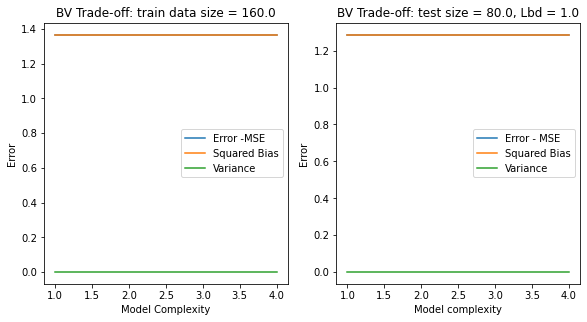

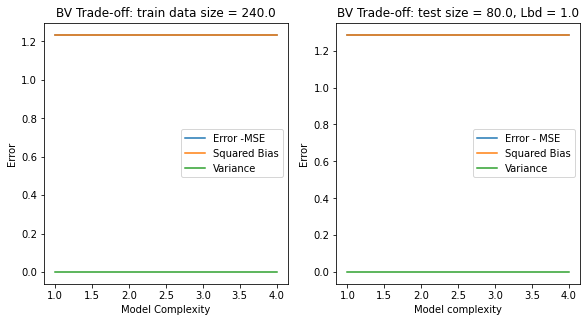

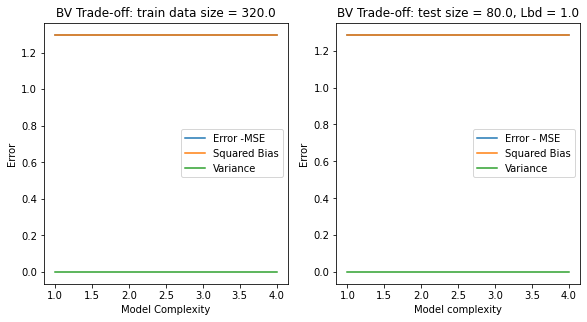

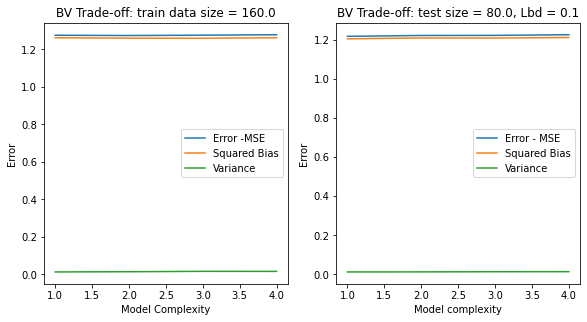

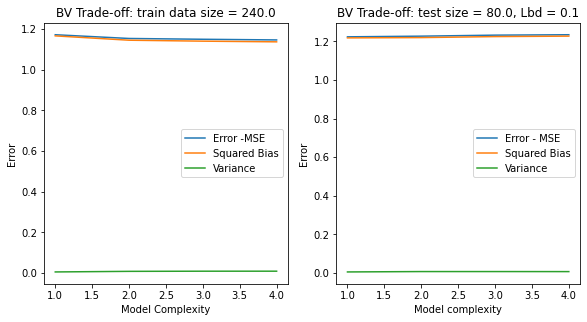

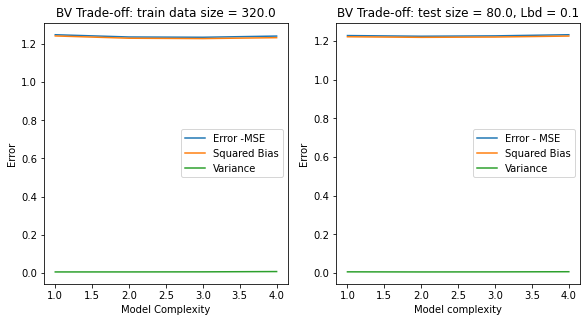

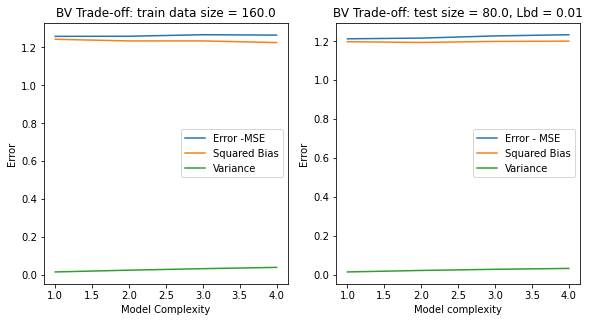

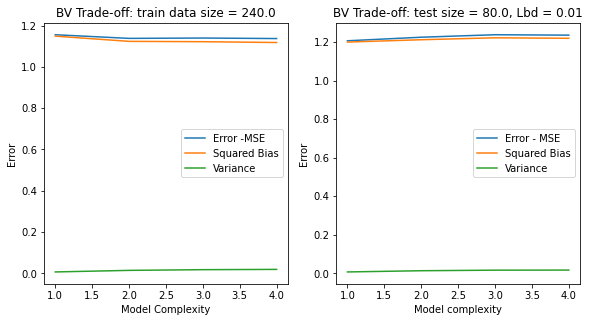

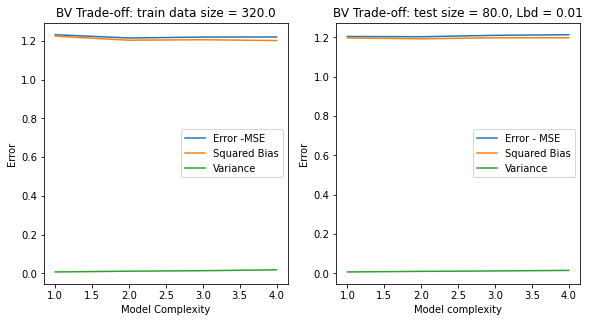

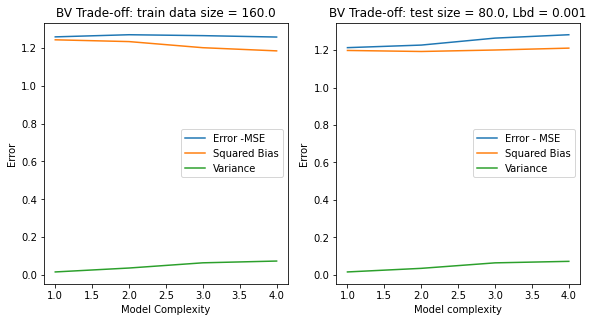

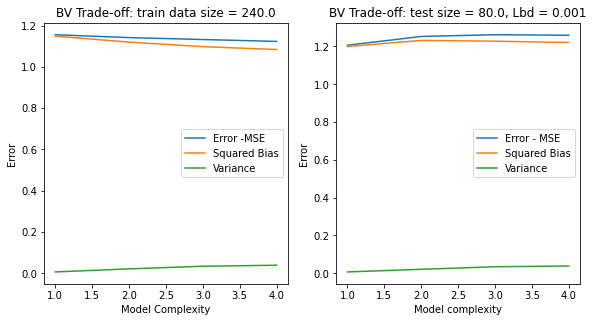

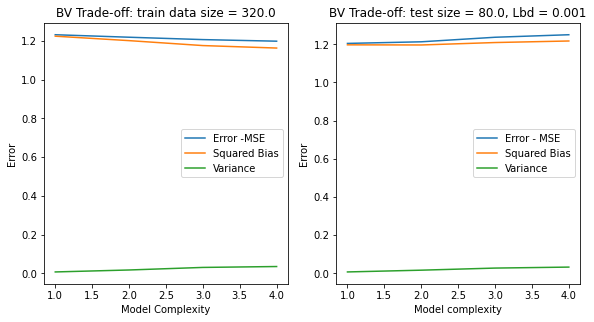

In [7]:
Maxpolydegree = np.max(degree_values)
polynomial = np.zeros(Maxpolydegree)

for polydegree in range(1, Maxpolydegree+1):
    polynomial[polydegree-1] = polydegree
    

for lbd in Lambda:

    #define the input argumets for the solver 
    solver_args ={ 'fit_intercept': False, 'alpha': lbd, 'max_iter' : 1200}


    error_test, bias_test, variance_test,error_train , bias_train , variance_train = bootstrap(features, labels , n_datapoints, degree_values, 
                               scaling= True , add_noise= True, mean = 0, std = 1,
                             solver= solver,  n_bootstraps= n_bootstraps, **solver_args)

    # plot bias-variance tradeoff
    for n,k in enumerate(n_datapoints): 
        f, (ax0, ax1) = plt.subplots(1, 2, figsize=(4.8*2, 4.8))

        ax0.plot(polynomial, error_train[:, n], label= 'Error -MSE')
        ax0.plot(polynomial, bias_train[:, n], label= 'Squared Bias')
        ax0.plot(polynomial, variance_train[:, n] , label= 'Variance')
        ax0.set_xlabel('Model Complexity')
        ax0.set_ylabel('Error')
        ax0.legend()
        ax0.set_title('BV Trade-off: train data size = '+str(np.round(k*0.8*len(labels), 2)))

        ax1.plot(polynomial, error_test[:, n], label= 'Error - MSE')
        ax1.plot(polynomial, bias_test[:, n], label= 'Squared Bias')
        ax1.plot(polynomial, variance_test[:, n], label= 'Variance')
        ax1.set_xlabel('Model complexity')
        ax1.set_ylabel('Error')
        ax1.legend()
        ax1.set_title('BV Trade-off: test size = '+str(np.round(0.2*len(labels), 2))+', Lbd = '+str(lbd))

        save_fig(f, name ='e_bv_tradeoff_n_'+str(int(k*0.8*len(labels)))+'Lambda-'+str(lbd)+'.png')

 

## Part e) : K-fold Cross validation 

In [8]:
k_values  = [5, 6, 7,8, 9, 10]  # Number of folds

degree_values = np.arange(1, 6)  # Specify degree of polynomial to be fitted

Lambda = [1e0, 1e-1, 1e-2, 1e-3 ]    # different values of Lambda

# define the model we want to use 
solver = Lasso



### K-fold cross validation

In [9]:
def gen_plot_kfold(n_datapoints, polynomial, estimated_mse, title , legend_label, fig_name):
    fig, ax = plt.subplots()
    for n,k in enumerate(n_datapoints):
        ax.plot(polynomial, np.log10(estimated_mse[:, n]), label= legend_label +', k = '+ str(k)  )
        ax.set_xlabel('Polynomial degree')
        ax.set_ylabel( 'np.log10[MSE]' )
        ax.set_xticks(polynomial)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        save_fig(fig , name =fig_name+ legend_label+'.png' )
    ax.set_title(title)
    plt.show()
    

In [10]:
def plot_kfold_implementation(features, labels , k_values, degree_values, fig_name, solver = RidgeRegression,
                              scaling= True , add_noise= True, mean = 0, std = 1, **solver_args):
    
    Maxpolydegree = np.max(degree_values)
    polynomial = np.zeros(Maxpolydegree)
    estimated_train_mse = np.zeros((Maxpolydegree,  len(k_values)))
    estimated_test_mse = np.zeros((Maxpolydegree,len(k_values)))

    if add_noise :
        np.random.seed(1)
        labels_n = labels +  np.random.normal(mean, std, labels.shape )
    else :
        labels_n = labels
    

    for polydegree in range(1, Maxpolydegree+1):
        polynomial[polydegree-1] = polydegree
        
    for degree in degree_values:
        # fit polynomials on test and train
        poly = PolynomialFeatures(degree, include_bias=not scaling)
        features_poly = poly.fit_transform(features)

        if scaling:
            # Scale data
            scaler = StandardScaler(with_std=True)
            feature_scale = scaler.fit_transform(features_poly)
            
        for n,k in enumerate(k_values):
            
            kf = KFoldCV()      #Implementation from resampling.py
            
            test_MSE, train_MSE = kf.cv(feature_scale, labels_n , degree, k, scaling = scaling,  solver = solver, **solver_args )
            

            estimated_train_mse[degree-1, n] = np.mean(train_MSE)
            estimated_test_mse[degree-1, n] = np.mean(test_MSE)

    print('MSE on test-set : \n',estimated_test_mse)

    #gen_plot_kfold(k_values, polynomial, estimated_train_mse,
    #         title = 'k-fold cv implementation for different order polynomials' ,
    #        y_label = 'MSE',
    #        legend_label = 'Train Error', fig_name = fig_name)

    gen_plot_kfold(k_values, polynomial, estimated_test_mse,
             title = 'k-fold cv implementation for different order polynomials' ,
            legend_label = 'Test Error', fig_name = fig_name)
    
    return estimated_test_mse
    





#### With noise


MSE on test-set : 
 [[1.29548038 1.29414759 1.29546792 1.29548038 1.29369195 1.29548038]
 [1.29548038 1.29414759 1.29546792 1.29548038 1.29369195 1.29548038]
 [1.29548038 1.29414759 1.29546792 1.29548038 1.29369195 1.29548038]
 [1.29548038 1.29414759 1.29546792 1.29548038 1.29369195 1.29548038]
 [1.29548038 1.29414759 1.29546792 1.29548038 1.29369195 1.29548038]]


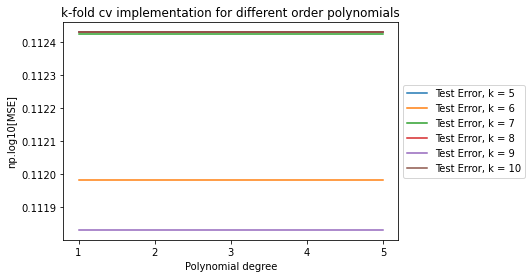

MSE on test-set : 
 [[1.35149496 1.33424072 1.3292042  1.32528691 1.30969353 1.30335836]
 [1.41361125 1.35871529 1.36276869 1.34957901 1.324805   1.3153426 ]
 [1.50400913 1.415241   1.42150505 1.39580837 1.35790493 1.34650613]
 [1.60211158 1.48129427 1.48385939 1.44885255 1.39179091 1.37435789]
 [1.69141383 1.54906356 1.55249085 1.51079229 1.42802429 1.40249858]]


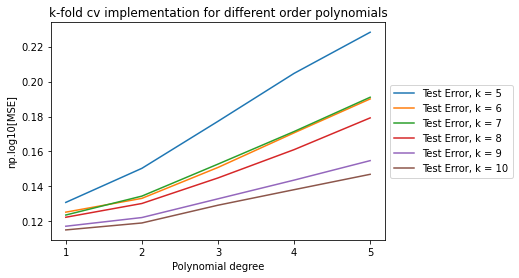

MSE on test-set : 
 [[1.37633605 1.34269923 1.33748037 1.33500615 1.31842294 1.31220609]
 [1.80289034 1.60388888 1.55536535 1.50728718 1.42722296 1.39696382]
 [2.00265516 1.75509238 1.68957771 1.6174702  1.50363046 1.46208652]
 [2.20195962 1.91752181 1.83555515 1.75387811 1.59806112 1.52473115]
 [2.44096472 2.11348542 2.0174374  1.93283134 1.72837459 1.61724661]]


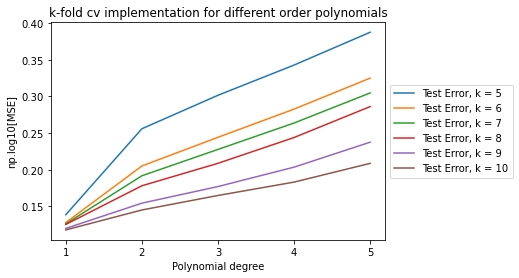

C:\Users\priya\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.93249911108887, tolerance: 0.04008978822529428
  model = cd_fast.enet_coordinate_descent(
C:\Users\priya\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13122943497529604, tolerance: 0.04031413156936007
  model = cd_fast.enet_coordinate_descent(
C:\Users\priya\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.151858845446043, tolerance: 0.04015630799735495
  model = cd_fast.enet_coordinate_descent(
C:\Users\priya\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Convergen

MSE on test-set : 
 [[1.37911036 1.3451144  1.34044471 1.33809686 1.32135987 1.31507052]
 [2.01730168 1.76647671 1.68585423 1.62233513 1.51545193 1.47312172]
 [2.78183853 2.41731213 2.19944395 2.06421717 1.80175914 1.6679426 ]
 [3.05564391 2.71419246 2.50359558 2.35850382 2.00522915 1.79903006]
 [3.24813931 2.97463474 2.84088049 2.71711078 2.28620168 1.98736046]]


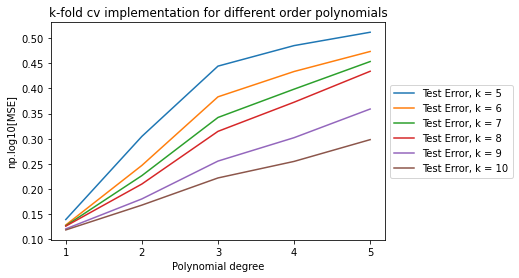

In [11]:
for lbd in Lambda:
    
    #define the input argumets for the solver 
    solver_args ={ 'fit_intercept': False, 'alpha': lbd, 'max_iter' : 1200}
    
    plot_kfold_implementation(features, labels ,k_values, degree_values, fig_name ='e_kfold_withnoise_lbd-'+str(lbd), solver = solver, **solver_args)
    
    plt.show()
    

#### Without noise

MSE on test-set : 
 [[0.26278502 0.26165552 0.26241884 0.26278502 0.26055846 0.26278502]
 [0.26278502 0.26165552 0.26241884 0.26278502 0.26055846 0.26278502]
 [0.26278502 0.26165552 0.26241884 0.26278502 0.26055846 0.26278502]
 [0.26278502 0.26165552 0.26241884 0.26278502 0.26055846 0.26278502]
 [0.26278502 0.26165552 0.26241884 0.26278502 0.26055846 0.26278502]]


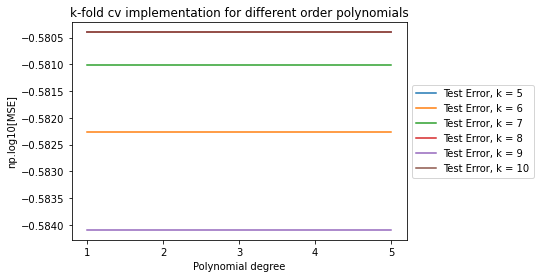

MSE on test-set : 
 [[0.32242708 0.30832514 0.29903477 0.29337953 0.2844775  0.27883259]
 [0.38767136 0.35012901 0.32559478 0.31160592 0.2974848  0.2920886 ]
 [0.45716958 0.39721892 0.35990588 0.33789078 0.31821631 0.30941357]
 [0.52680912 0.44858639 0.39758144 0.36349553 0.33749284 0.32387477]
 [0.57078069 0.49766693 0.4348904  0.38355176 0.3449582  0.32752264]]


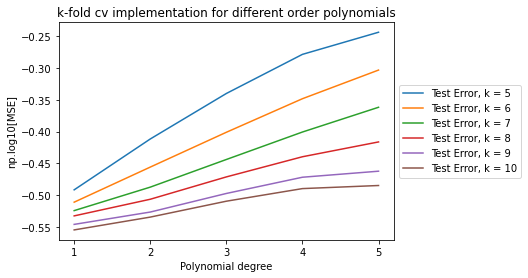

MSE on test-set : 
 [[0.35993472 0.33096755 0.31007792 0.30068858 0.2901727  0.28615973]
 [0.65167937 0.52479387 0.43800952 0.39529629 0.35473873 0.33966889]
 [0.81012163 0.64838064 0.52926002 0.46204848 0.40465472 0.38068614]
 [0.95925674 0.7731602  0.62825245 0.53223469 0.46237951 0.42945791]
 [1.10640385 0.89579624 0.73335676 0.62376375 0.5343174  0.49346783]]


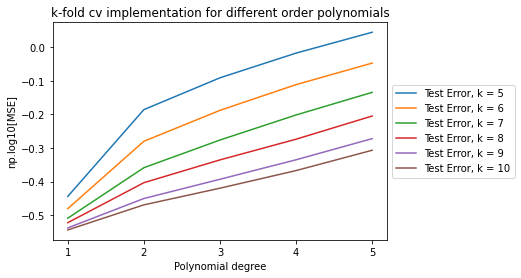

C:\Users\priya\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7010706498247252, tolerance: 0.007015605121081356
  model = cd_fast.enet_coordinate_descent(
C:\Users\priya\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.040374294188154636, tolerance: 0.006012074478787238
  model = cd_fast.enet_coordinate_descent(
C:\Users\priya\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3673225316571731, tolerance: 0.008728391136089574
  model = cd_fast.enet_coordinate_descent(
C:\Users\priya\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

MSE on test-set : 
 [[0.36298062 0.33376528 0.31274348 0.303282   0.29280621 0.2888721 ]
 [0.84934323 0.67704712 0.55563476 0.49035887 0.43224176 0.402939  ]
 [1.41515569 1.1642357  0.93726787 0.77941647 0.63793933 0.57069193]
 [1.61807989 1.37775484 1.1235363  0.95139165 0.75815133 0.65333939]
 [1.72091756 1.54008518 1.30837668 1.13784671 0.9057316  0.77772348]]


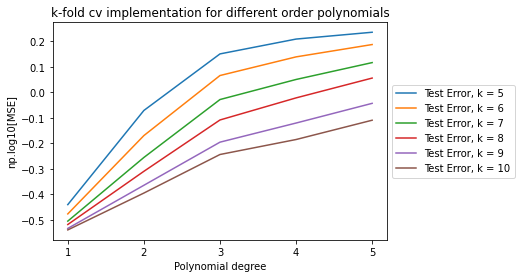

In [12]:
for lbd in Lambda:
    
    #define the input argumets for the solver 
    solver_args ={ 'fit_intercept': False, 'alpha': lbd, 'max_iter' : 1200}
    
    plot_kfold_implementation(features,labels , k_values, degree_values, scaling= True, add_noise= False, fig_name ='e_kfold_without_noise_lbd-'+str(lbd),solver = solver, **solver_args )
    
    plt.show()
    
    
    
